In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(word):
    X, y = [], []
    
    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

torch.Size([228146, 3]) torch.Size([228146])
torch.Size([228146, 3]) torch.Size([228146])
torch.Size([228146, 3]) torch.Size([228146])


In [12]:
# MLP revised
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.001 #close to 0
b2 = torch.randn(vocab_size, generator=g) * 0 # intialize with zeros

parameters = [C, w1, b1, w2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]
    
    #forward
    emb = C[Xb] #embed
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ w1 + b1 #hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, yb)
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2983
  10000/ 200000: 2.0225
  20000/ 200000: 1.8216
  30000/ 200000: 2.0445
  40000/ 200000: 2.0482
  50000/ 200000: 2.1613
  60000/ 200000: 2.2720
  70000/ 200000: 2.1777
  80000/ 200000: 2.0422
  90000/ 200000: 1.8497
 100000/ 200000: 2.1809
 110000/ 200000: 2.0370
 120000/ 200000: 2.0783
 130000/ 200000: 1.8332
 140000/ 200000: 1.7076
 150000/ 200000: 2.3976
 160000/ 200000: 2.0469
 170000/ 200000: 2.2803
 180000/ 200000: 2.0380
 190000/ 200000: 2.0217


In [8]:
# we expect a probability of 1/27 for each character - uniform distribution
# the loss hence, would be -log of that number

-torch.tensor(1/27.0).log()

tensor(3.2958)

(array([2280.,  141.,   73.,   75.,   51.,   45.,   54.,   29.,   27.,
          25.,   32.,   41.,   17.,   16.,   26.,   19.,   20.,   20.,
          25.,   18.,   11.,   19.,   14.,   16.,   30.,   28.,    8.,
          20.,   14.,   20.,   20.,   28.,   17.,   18.,   15.,   22.,
          14.,   33.,   23.,   21.,   24.,   29.,   58.,   36.,   57.,
          67.,   66.,  101.,  123., 2414.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

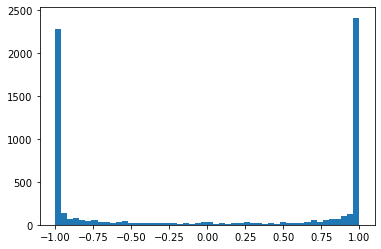

In [14]:
plt.hist(h.view(-1).tolist(), 50)

In [9]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0 ]) #the logits should be equal at initialization
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [13]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, ytr),
        'val': (Xdev, ydev),
        'test': (Xte, yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1253464221954346
val 2.1253464221954346


In [15]:
# sampe from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True: 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carmahzamillivi.
kimrix.
taty.
skanden.
jazhuel.
delynn.
jareen.
nellara.
chaiir.
kaleigh.
ham.
prin.
quint.
sulin.
alianni.
wraelo.
dearynn.
jace.
pirraylen.
edi.


In [18]:
# we should know what to expect 

-torch.tensor(1/27.0).log() # this is the loss we would expect at initialization

tensor(3.2958)